# Introduction
Modern GPU clusters run thousands of different machine-learning jobs at the same time. Each job requests certain GPU or CPU resources. It may need several workers and can only run on compatible GPU types. Poor scheduling leads to long wait times, underused GPUs, uneven distribution of worker processes, and high communication costs when a job’s workers are spread across multiple nodes.

The goal is to create a multi-objective optimization model for assigning jobs to GPU cluster nodes. This will use real data from the Alibaba cluster dataset: https://github.com/alibaba/clusterdata/tree/master/cluster-trace-v2026-spot-gpu.

The model aims to balance three competing goals:
- Minimize latency penalty; older jobs should start sooner.
- Maximize GPU use; ensure high occupancy of expensive accelerators.
- Minimize communication costs; avoid splitting jobs across nodes unnecessarily.

Since these goals conflict with each other, we use both lexicographic optimization and multi-objective Pareto analysis. This includes ε-constraint and normalized-weight methods to explore the trade-offs. We also factor in uncertainty by considering scenarios of high and low load to see how these conditions affect outcomes.

## Description of the Approach

The workflow of the project consists of four components:

### (A) Data Selection & Preprocessing

- Select jobs submitted by organization 13.
- Sort by submit time so older jobs receive higher scheduling priority.
- Compute latency weights using normalized (max - timestamp) scaling.
- Sample nodes proportionally to job GPU model distribution to preserve cluster heterogeneity.

(B) GAMSPy Optimization Framework

We use GAMSPy to:

- Declare sets for jobs (I) and nodes (N)
Construct parameters for CPU/GPU requirements, workers, GPU compatibility
Define decision variables:
- x(i,n) – workers of job i assigned to node n
- z(i,n) – binary indicator of job-node usage
- y(i) – job acceptance (binary)

(C) Core Constraints

Worker balance: $$ \sum_{n} x_{i,n} = \text{workers}_i \cdot y_i$$

Resource feasibility:

- CPU & GPU capacity constraints per node
- GPU-model compatibility constraints

Splitting behavior: To measure communication overhead: $$ \sum_{n} z_{i,n} - y_i $$



(D) Multi-Objective Optimization

We implemented three different optimization approaches:

- Three-stage optimization

    - Stage 1: minimize latency
    - Stage 2: maximize GPU utilization while keeping latency within 5%
    - Stage 3: minimize communication overhead while satisfying Stages 1–2

-  Weighted-objective model:  Assign weights accordigly to each factor and tweak them accordingly: $$ 
\min  \alpha \cdot \text{LatencyPen}
\;+\; \gamma \cdot \text{CommOverhead}
\;-\; \beta \cdot \text{GPUUtil}
$$

 $$ \alpha + \beta + \gamma = 1$$

- Stochastic Model: I extend the model with a scenario-based stochastic layer, where a small set of runtime/load scenarios
$S = \{S_1, S_2, S_3\}$ with probabilities $p_s$ modify the job durations but share the same
assignment decisions $x_{i,n}, z_{i,n}, y_i$. For each scenario $s \in S,$ I recompute
$\text{LatencyPen}_s$, $\text{GPUUtil}_s$, and $\text{CommOverhead}_s$, and then minimize the
expected weighted cost $$
\sum_{s \in S} p_s \bigl(
    \alpha \,\text{LatencyPen}_s
    - \beta \,\text{GPUUtil}_s
    + \gamma \,\text{CommOverhead}_s
\bigr)$$



In [71]:
import math
import numpy as np
import pandas as pd
import gamspy as gp
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum
import matplotlib.pyplot as plt

In [72]:
jobs_df  = pd.read_csv("job_info_df.csv")

In [73]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466867 entries, 0 to 466866
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   job_name      466867 non-null  int64  
 1   organization  466867 non-null  int64  
 2   gpu_model     466867 non-null  object 
 3   cpu_request   466867 non-null  float64
 4   gpu_request   466867 non-null  float64
 5   worker_num    466867 non-null  int64  
 6   submit_time   466867 non-null  float64
 7   duration      466867 non-null  float64
 8   job_type      466867 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 32.1+ MB


In [77]:
# extract jobs submitted by org 13 and Sort jobs by submit_time (older jobs first)
jobs_df = jobs_df[jobs_df["organization"] == 13].copy()
jobs_df = jobs_df.sort_values("submit_time").reset_index(drop=True)
jobs_df = jobs_df.head(100).copy()

# Index jobs by job_name (assumed unique integer ID)
df_i = jobs_df.set_index("job_name")

print("Jobs:", len(jobs_df))

Jobs: 100


In [78]:
jobs_df.head()

,job_name,organization,gpu_model,cpu_request,gpu_request,worker_num,submit_time,duration,job_type
0,239255,13,A10,20.0,1.0,1,0.0,2764799.0,HP
1,203555,13,GPU-series-1,32.0,1.0,1,0.0,2159999.0,HP
2,203554,13,GPU-series-1,32.0,1.0,1,0.0,2246399.0,HP
3,203553,13,GPU-series-1,32.0,1.0,1,0.0,1036799.0,HP
4,203552,13,GPU-series-1,32.0,1.0,1,0.0,2159999.0,HP


In [79]:
jobs_df['gpu_model'].value_counts()

gpu_model
GPU-series-1    82
A10             18
Name: count, dtype: int64

In [80]:
nodes_df = pd.read_csv("node_info_df.csv")

In [81]:
nodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gpu_model         4278 non-null   object
 1   gpu_capacity_num  4278 non-null   int64 
 2   cpu_num           4278 non-null   int64 
 3   node_name         4278 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 133.8+ KB


In [82]:
# Compute job ratios
job_counts = jobs_df['gpu_model'].value_counts()
total_jobs = job_counts.sum()

ratio_dict = (job_counts / total_jobs).to_dict()
total_nodes_needed = total_jobs/3
print(total_nodes_needed)

# -------------------------------------------------------
# Allocate proportional node counts
# -------------------------------------------------------
# each model gets proportional count, minimum 1
target_counts = {
    model: max(1, int(round(ratio * total_nodes_needed)))
    for model, ratio in ratio_dict.items()
}

print("Target node counts (min 1 each):")
print(target_counts)

# -------------------------------------------------------
# Sample nodes for each GPU model
# -------------------------------------------------------
sampled = []

for model, count in target_counts.items():
    subset = nodes_df[nodes_df["gpu_model"] == model]

    take = min(count, len(subset))  # cannot take more than available
    sampled.append(subset.sample(take, random_state=0))

# Combine sampled nodes
nodes_sampled = pd.concat(sampled).sample(frac=1, random_state=0)

print("\nFinal sampled node distribution:")
print(nodes_sampled["gpu_model"].value_counts())
print(f"\nTotal sampled nodes: {len(nodes_sampled)}")


33.333333333333336
Target node counts (min 1 each):
{'GPU-series-1': 27, 'A10': 6}

Final sampled node distribution:
gpu_model
GPU-series-1    27
A10              6
Name: count, dtype: int64

Total sampled nodes: 33


In [83]:
nodes_df = nodes_sampled

In [84]:
nodes_df["gpu_model"].value_counts()

gpu_model
GPU-series-1    27
A10              6
Name: count, dtype: int64

## (3) Optimization model and its solution
#### For the options, the time limit is set to 900 seconds(15 mins) because running all models above this time for the current scenario leads to memory issues and the execution halts.

In [120]:
options = gp.Options(threads=8, relative_optimality_gap=0.10, time_limit=900)

#### Sets:
- Set I = all jobs
- Set N = all nodes

In [121]:
#  Container & Sets
m = Container(options=options)
# m = Container()
I = Set(m, "i", records=[str(i) for i in df_i.index.tolist()])
N = Set(m, "n", records=nodes_df["node_name"].tolist(), description="nodes")

#### Parameters
Job-side parameters:
- cpu_req(i):total CPU cores requested by job i (from cpu_request)
- gpu_req(i): total GPUs requested by job i (from gpu_request).
- workers(i): number of workers required by job i (from worker_num).
- gpu_job(i): GPU indicator: $$ \text{gpu\_job}(i) =
\begin{cases}
1, & \text{if } \text{gpu\_req}(i) > 0, \\
0, & \text{otherwise}.
\end{cases}$$

#### Priority / latency weight: 
- Latency weight (i); normalized priority from submit time - $$ \text{latency\_weight}(i)
=
\frac{\max(\text{submit\_time}) - \text{submit\_time}(i)}
{\max(\text{submit\_time}) - \min(\text{submit\_time})}$$

- Per-worker resource usage:
    - CPU per worker $$ \text{cpu\_pw}(i) = \frac{\text{cpu\_req}(i)}{\text{workers}(i)}. $$
    - GPU per worker $$ \text{gpu\_pw}(i) = \frac{\text{gpu\_req}(i)}{\text{workers}(i)}. $$


- Node side capacities:
  - Available CPU cores on node (scaled + randomized): $\text{cpu\_cap}(n)=\text{cpu\_num}(n)\cdot\text{capacity\_scale}\cdot(0.9+0.2U),\;U\sim\text{Uniform}(0,1)$
  - Available GPUs on node  n (same form as CPU).
    

- GPU compatibility
  - node_gpu_model(n): GPU type on node n
  - compat(i,n): 1 if job i can run on node n (CPU jobs always OK; GPU jobs require GPU+matching model), else 0.


In [122]:
# Job-side Parameters
def make_param(name, col):
    tmp = df_i[[col]].reset_index()
    tmp.columns = ["i", "value"]
    tmp["i"] = tmp["i"].astype(str)  # align with Set I labels
    return Parameter(m, name=name, domain=[I], records=tmp)

cpu_req = make_param("cpu_req", "cpu_request")
gpu_req = make_param("gpu_req", "gpu_request")

In [123]:
# workers(i) given directly
workers_df = df_i[["worker_num"]].reset_index()
workers_df.columns = ["i", "value"]
workers_df["i"] = workers_df["i"].astype(str)
workers = Parameter(m, "workers", domain=[I], records=workers_df)

In [124]:
# GPU job indicator
gpu_job_df = (df_i["gpu_request"] > 0).astype(int).reset_index()
gpu_job_df.columns = ["i", "value"]
gpu_job_df["i"] = gpu_job_df["i"].astype(str)
gpu_job = Parameter(m, "gpu_job", domain=[I], records=gpu_job_df)

In [125]:
# -------- Latency weights from submit_time (normalized) --------
submit_series = df_i["submit_time"]
submit_min = submit_series.min()
submit_max = submit_series.max()

# Larger weight for older jobs (smaller submit_time)
raw_lat = submit_max - submit_series
range_lat = raw_lat.max() - raw_lat.min()
if range_lat == 0:
    # When all submit times identical; use uniform weights to avoid NaN
    lat_norm = pd.Series(1.0, index=raw_lat.index)
else:
    lat_norm = (raw_lat - raw_lat.min()) / range_lat

lat_df = lat_norm.reset_index()
lat_df.columns = ["i", "value"]
lat_df["i"] = lat_df["i"].astype(str)
latency_weight = Parameter(m, "latency_weight", domain=[I], records=lat_df)

In [126]:
# -------- Per-worker resource consumption --------
def per_worker_param(name, total_series):
    tmp = (total_series / df_i["worker_num"]).reset_index()
    tmp.columns = ["i", "value"]
    tmp["i"] = tmp["i"].astype(str)
    return Parameter(m, name=name, domain=[I], records=tmp)

cpu_pw = per_worker_param("cpu_pw", df_i["cpu_request"])
gpu_pw = per_worker_param("gpu_pw", df_i["gpu_request"])

In [127]:
# Node-side Parameters (CPU & GPU capacities with scaling + randomization)

# Scaled capacities down and add light randomization to create more trade-offs
capacity_scale = 0.9  # try 0.3–0.5 for variety

nodes_df["cpu_num_scaled"] = (
    nodes_df["cpu_num"]
    * capacity_scale
    * (0.9 + 0.2 * np.random.rand(len(nodes_df)))
)
nodes_df["gpu_cap_scaled"] = (
    nodes_df["gpu_capacity_num"]
    * capacity_scale
    * (0.9 + 0.2 * np.random.rand(len(nodes_df)))
)

cpu_cap_df = nodes_df[["node_name", "cpu_num_scaled"]].rename(
    columns={"node_name": "n", "cpu_num_scaled": "value"}
)
gpu_cap_df = nodes_df[["node_name", "gpu_cap_scaled"]].rename(
    columns={"node_name": "n", "gpu_cap_scaled": "value"}
)

cpu_cap = Parameter(m, "cpu_cap", domain=[N], records=cpu_cap_df)
gpu_cap = Parameter(m, "gpu_cap", domain=[N], records=gpu_cap_df)

# GPU model on each node
node_gpu_model = nodes_df.set_index("node_name")["gpu_model"].to_dict()


In [128]:
# GPU-model compatibility compat(i,n)
rows = []
for i_val, job in df_i.iterrows():
    j_model = job["gpu_model"]
    j_gpu_req = job["gpu_request"]
    for _, n_row in nodes_df.iterrows():
        n_val = n_row["node_name"]
        n_model = n_row["gpu_model"]
        n_gpu_cap = n_row["gpu_capacity_num"]

        if j_gpu_req > 0:  # GPU job: must have GPU and match model
            ok = int(n_gpu_cap > 0 and (n_model == j_model))
        else:              # CPU-only job can run anywhere
            ok = 1
        rows.append((str(i_val), n_val, ok))

compat_df = pd.DataFrame(rows, columns=["i", "n", "value"])
compat = Parameter(m, "compat", domain=[I, N], records=compat_df)

### Decision Variables:
- $x_{i,n}$: represents the number of workers of job \(i\) assigned to node \(n\), capturing how a job is distributed across the cluster.
- $z_{i,n}$: is a binary variable indicating whether job \(i\) uses node \(n\), enabling modeling of communication overhead when jobs span multiple nodes.
- $y_i$: is a binary acceptance variable that determines whether job \(i\) is scheduled at all.


In [129]:
# x(i,n): number of workers of job i on node n 
x = Variable(m, "x", domain=[I, N], type="positive")
x.lo[I, N] = 0

# z(i,n): job i uses node n (binary)
z = Variable(m, "z", domain=[I, N], type="binary")

# y(i): job accepted/scheduled (binary)
y = Variable(m, "y", domain=[I], type="binary")

#### Constraints for all models:
- Worker balance: ensures each accepted job gets exactly its required workers: $$ \sum_n x_{i,n} = \text{workers}_i \, y_i\ $$.
- Linking \(x\) to node usage \(z\): workers can be placed on a node only if that node is activated for the job: $$ x_{i,n} \le \text{workers}_i \, z_{i,n}\ $$.
- Use only if accepted: a job cannot use any node unless it is accepted: $$ z_{i,n} \le y_i\ $$.
- GPU compatibility: job workers can only be assigned to compatible nodes (GPU model/availability): $$ x_{i,n} \le \text{workers}_i \ , \text{compat}_{i,n} $$.
- Node CPU/GPU capacity: total CPU/GPU load assigned to each node cannot exceed its capacity: $$ \sum_i \text{cpu\_pw}_i x_{i,n} \le \text{cpu\_cap}_n  ,  \sum_i \text{gpu\_pw}_i x_{i,n} \le \text{gpu\_cap}_n $$


In [130]:
# Base Constraints (shared by all models)

# Worker balance: sum_n x(i,n) = workers(i) * y(i)
worker_balance = Equation(m, "worker_balance", domain=[I])
worker_balance[I] = Sum(N, x[I, N]) == workers[I] * y[I]

# Workers imply node usage (soft linking via big-M)
link_xz = Equation(m, "link_xz", domain=[I, N])
link_xz[I, N] = x[I, N] <= workers[I] * z[I, N]

# Node usage only if job accepted
use_only_if_accepted = Equation(m, "use_only_if_accepted", domain=[I, N])
use_only_if_accepted[I, N] = z[I, N] <= y[I]

# GPU-model compatibility
gpu_compat = Equation(m, "gpu_compat", domain=[I, N])
gpu_compat[I, N] = x[I, N] <= workers[I] * compat[I, N]

# Node CPU capacity
cpu_con = Equation(m, "cpu_con", domain=[N])
cpu_con[N] = Sum(I, cpu_pw[I] * x[I, N]) <= cpu_cap[N]

#Node GPU capacity
gpu_con = Equation(m, "gpu_con", domain=[N])
gpu_con[N] = Sum(I, gpu_pw[I] * x[I, N]) <= gpu_cap[N]

# Save base equations
base_equations = m.getEquations().copy()


# Objective components (symbolic)
LatencyPen_expr   = Sum(I, latency_weight[I] * (1 - y[I]))
GPUUtil_expr      = Sum([I, N], gpu_pw[I] * x[I, N])
CommOverhead_expr = Sum(I, (Sum(N, z[I, N]) - y[I]))

The compute_kpis() function extracts the current solution and computes latency time of executing all jobs, total GPU utilization units from worker assignments, and communication overhead units from job splitting across nodes. These KPIs are used to evaluate and compare solutions across different optimization models.

In [131]:
# Helper to compute KPI values from current solution
def compute_kpis():
    # print(y)
    # if y is None:
    #     return 0,0,0
    # -------------------------------
    # y(i)
    # -------------------------------
    y_df = y.records[["i", "level"]].copy()
    y_df["i"] = y_df["i"].astype(str)
    y_df = y_df.rename(columns={"level": "y"})

    lat_df = latency_weight.records[["i", "value"]].copy()
    lat_df["i"] = lat_df["i"].astype(str)
    lat_df = lat_df.rename(columns={"value": "w"})

    # print(y_df, lat_df)
    
    merge_y = pd.merge(lat_df, y_df, on="i", how="left")
    merge_y["y"] = merge_y["y"].astype(float).fillna(0.0)
    LP = float((merge_y["w"] * (1.0 - merge_y["y"])).sum())

    # -------------------------------
    # x(i,n)
    # -------------------------------
    x_df = x.records[["i", "n", "level"]].copy()
    x_df["i"] = x_df["i"].astype(str)
    x_df["n"] = x_df["n"].astype(str)
    x_df = x_df.rename(columns={"level": "x"})

    gpu_pw_df = gpu_pw.records[["i", "value"]].copy()
    gpu_pw_df["i"] = gpu_pw_df["i"].astype(str)
    gpu_pw_df = gpu_pw_df.rename(columns={"value": "gpu_pw"})

    merge_x = pd.merge(x_df, gpu_pw_df, on="i", how="left")
    merge_x["x"] = merge_x["x"].astype(float)
    merge_x["gpu_pw"] = merge_x["gpu_pw"].astype(float).fillna(0.0)

    # print(x_df, gpu_pw_df)
    GU = float((merge_x["x"] * merge_x["gpu_pw"]).sum())

    # -------------------------------
    # z(i,n)
    # -------------------------------
    z_df = z.records[["i", "n", "level"]].copy()
    z_df["i"] = z_df["i"].astype(str)
    z_df["n"] = z_df["n"].astype(str)
    z_df = z_df.rename(columns={"level": "z"})

    z_df["z"] = z_df["z"].astype(float)
    z_sum = z_df.groupby("i")["z"].sum().reset_index()

    merge_z = pd.merge(z_sum, y_df, on="i", how="left")
    merge_z["y"] = merge_z["y"].astype(float).fillna(0.0)
    merge_z["co"] = merge_z["z"] - merge_z["y"]

    # print(z_df)

    CO = float(merge_z["co"].sum())
    
    return LP, GU, CO


### Optimization models:
    
#### Model-1
This is a **3-stage optimization**.  
First, the model minimizes the total latency penalty to prioritize older jobs.  
Second, it maximizes GPU utilization while allowing latency to increase by at most 5%.  
Finally, it minimizes communication overhead while keeping both latency and GPU utilization close to their previously optimal values.
The final model takes too long to run and the RAM runs out of memory which is the reason it is capped at 15 mins. 

In [132]:
#  3-stage optimization

# ------------------ Model 1: Minimize LatencyPen ----------------
print("\n=== MODEL 1: Minimize LatencyPen ===")

model1 = Model(
    m,
    name="LatencyModel",
    equations=base_equations,
    objective=LatencyPen_expr,
    sense="min",
    problem="MIP",
)

model1.solve()


=== MODEL 1: Minimize LatencyPen ===


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,57.0,10067,6701,MIP,CPLEX,0.027


In [133]:
L_star, G_tmp, C_tmp = compute_kpis()
print("Best LatencyPen =", L_star)

Best LatencyPen = 57.0


In [134]:
# # ------------------ Model 2: Maximize GPUUtil with LatencyPen<= L* ----
print("\n=== MODEL 2: Maximize GPUUtil with LatencyPen <= 1.05 times ===")

latency_limit = Equation(m, "latency_limit")
latency_limit[...] = LatencyPen_expr <= 1.05 * L_star
latency_limit[...] = LatencyPen_expr >= 0

model2 = Model(
    m,
    name="GPUModel",
    equations=base_equations + [latency_limit],
    objective=GPUUtil_expr,
    sense="max",
    problem="MIP",
)

model2.solve()


=== MODEL 2: Maximize GPUUtil with LatencyPen <= 1.05 times ===


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,Integer,43.0,10068,6701,MIP,CPLEX,0.126


In [135]:
L2, G_star, C2 = compute_kpis()
print("Best GPUUtil =", G_star)

Best GPUUtil = 43.0


In [136]:
# # ------------------ Model 3: Minimize CommOverhead given L*, G* ------
print("\n=== MODEL 3: Minimize CommOverhead with Latency & GPU fixed ===")

gpu_fix = Equation(m, "gpu_fix")
gpu_fix[...] = GPUUtil_expr >= (G_star - G_star*0.05)

model3 = Model(
    m,
    name="CommModel",
    equations=base_equations + [latency_limit, gpu_fix],
    objective=CommOverhead_expr,
    sense="min",
    problem="MIP",
)

model3.solve()


=== MODEL 3: Minimize CommOverhead with Latency & GPU fixed ===


[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,26.0,10069,6701,MIP,CPLEX,900.908


In [137]:
L3, G3, C_star = compute_kpis()
print("Best CommOverhead =", C_star)

Best CommOverhead = 26.0


#### Model-2:
This is a **weighted multi-objective optimization model** that combines latency penalty, GPU utilization, and communication overhead into a single objective function.  
The weights $$  \alpha, \beta, \gamma $$ are normalized to sum to one, reflecting their relative importance.  
The model minimizes a weighted cost that penalizes latency and communication while rewarding higher GPU utilization.

In [97]:
# Weighted multi-objective model

alpha = 0.6 # latency weight
beta  = 0.3  # GPU util weight
gamma = 0.1   # communication penalty weight

#normalize wts
S = alpha + beta + gamma
alpha = alpha / S
beta  = beta / S
gamma = gamma / S

In [28]:
WeightedObj_expr = alpha * LatencyPen_expr + gamma * CommOverhead_expr - beta * GPUUtil_expr

modelW = Model(
    m,
    name="WeightedMultiObj",
    equations=base_equations,
    objective=WeightedObj_expr,
    sense="min",
    problem="MIP",
)

modelW.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,Integer,24.1,10067,6701,MIP,CPLEX,30.474


In [29]:
LW, GW, CW = compute_kpis()
print("\nWeighted multi-objective solution:", "LatencyPen =", LW, "GPUUtil =", GW, "CommOverhead =", CW)


Weighted multi-objective solution: LatencyPen = 57.0 GPUUtil = 43.0 CommOverhead = 28.0


### Comparison of the above two models:
While model-1 doesnt require a person to adjust the weights, the processing time is way too long. The second model allows the flexibility for choosing the importance for each of the objectives. Hence there is a tradeoff here it depends on the use case to deem which model is better.

### Model-3
This is a scenario-based stochastic extension of the scheduling model that captures uncertainty in job runtimes and system load.  
A small set of scenarios with associated probabilities modifies job runtimes, while assignment decisions remain common across all scenarios.  
The model minimizes the expected weighted cost of latency, GPU utilization, and communication overhead across scenarios.

In [98]:
# ============================================================
# STOCHASTIC EXTENSION (Scenario Model)
# ============================================================

print("\n=== BUILDING STOCHASTIC MODEL (SCENARIO-BASED) ===")

# ------------------------------------------------------------
# Scenario set and probabilities
# ------------------------------------------------------------

S = Set(m, "s", records=["S1", "S2", "S3"], description="scenarios")

prob_df = pd.DataFrame({
    "s": ["S1", "S2", "S3"],
    "value": [0.5, 0.3, 0.2]  
})
p = Parameter(m, "p", domain=[S], records=prob_df)

# ------------------------------------------------------------
# Scenario-dependent uncertain parameters
#    Example: runtime uncertainty (can be changed to GPU or CPU capacity)
# ------------------------------------------------------------

rows = []
for (i_val, base_row) in df_i.iterrows():
    base_runtime = base_row["cpu_request"]

    rows.append((i_val, "S1", base_runtime * 1.00))   # baseline
    rows.append((i_val, "S2", base_runtime * 1.30))   # heavy load
    rows.append((i_val, "S3", base_runtime * 0.85))   # light load

duration_s = Parameter(
    m, "duration_s",
    domain=[I, S],
    records=pd.DataFrame(rows, columns=["i","s","value"])
)

# ------------------------------------------------------------
# Scenario recourse variables
# ------------------------------------------------------------

GPUUtil_s      = Variable(m, "GPUUtil_s",      domain=[S])
CommOverhead_s = Variable(m, "CommOverhead_s", domain=[S])
LatencyPen_s   = Variable(m, "LatencyPen_s",   domain=[S])

# ------------------------------------------------------------
# Scenario-level definitions (recourse equations)
# ------------------------------------------------------------

latency_def = Equation(m, "latency_def", domain=[S])
latency_def[S] = LatencyPen_s[S] == Sum(I, latency_weight[I] * (1 - y[I]))

gpu_def = Equation(m, "gpu_def", domain=[S])
gpu_def[S] = GPUUtil_s[S] == Sum([I, N], gpu_pw[I] * x[I,N])

comm_def = Equation(m, "comm_def", domain=[S])
comm_def[S] = CommOverhead_s[S] == Sum(I, (Sum(N, z[I,N]) - y[I]))

# ------------------------------------------------------------
# Stochastic objective
# ------------------------------------------------------------

StochasticObj = Sum(S,
        p[S] * (
            alpha * LatencyPen_s[S]
            - beta  * GPUUtil_s[S]
            + gamma * CommOverhead_s[S]
        )
)

model_stoch = Model(
    m,
    name="StochasticModel",
    equations=base_equations + [latency_def, gpu_def, comm_def],
    objective=StochasticObj,
    sense="min",
    problem="MIP"
)

print("Solving stochastic model...")
model_stoch.solve()


=== BUILDING STOCHASTIC MODEL (SCENARIO-BASED) ===
Solving stochastic model...


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,Integer,25.0,10076,6710,MIP,CPLEX,17.948


In [100]:
LPs, GUs, COs = compute_kpis()
print("Stochastic model solved.")
print("KPIs:", LPs, GUs, COs)

Stochastic model solved.
KPIs: 58.0 42.0 28.0


## (4) Visualizations
I generate many weight triples α+β+γ=1. For each triple I solve the same MIP using the same multi weighted objective
$$ \min  \alpha \cdot \text{LatencyPen}
\;+\; \gamma \cdot \text{CommOverhead}
\;-\; \beta \cdot \text{GPUUtil}
$$

then record the resulting (LatencyPen,GPUUtil,CommOverhead). This produces a set of trade-off, Pareto solutions.

#### Note: these plots were loaded separately as it took almost 45 mins to generate these plots. Hence I've commented the code

In [ ]:
'''
import numpy as np

weights = []
step = 0.05 

for a in np.arange(0, 1+1e-9, step):
    for b in np.arange(0, 1-a+1e-9, step):
        g = 1 - a - b
        if g < 0: continue
        weights.append((a, b, g))

print("Total weight triples:", len(weights))
'''

In [ ]:
'''
# Pareto with NORMALIZED weights (α+β+γ = 1)
results = []

print("\nRunning Pareto sweep with normalized weights...")

results = []
for (a,b,g) in weights:
    W_expr = a*LatencyPen_expr + g*CommOverhead_expr - b*GPUUtil_expr
    modelP = Model(
        m,
        name="ParetoModel",
        equations=base_equations,
        objective=W_expr,
        sense="min",
        problem="MIP",
    )
    _ = modelP.solve()
    LP, GU, CO = compute_kpis()
    results.append((LP, GU, CO, alpha, beta, gamma))
    print(f"α={a:.3f}, β={b:.3f}, γ={g:.3f} -- "f"Lat={LP:.2f}, GPU={GU:.2f}, Comm={CO:.2f}")

pareto_df = pd.DataFrame(
    results,
    columns=["LatencyPen", "GPUUtil", "CommOverhead", "alpha", "beta", "gamma"]
)

print("Pareto sample:")
print(pareto_df.head())
'''

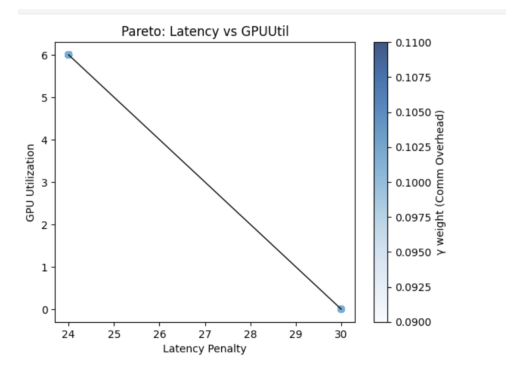

In [6]:
'''
# 3× 2D Pareto plots (with normalized weights)

# plt.figure(figsize=(15,4))

# Plot 1: Latency vs GPUUtil

# plt.subplot(1,3,1)
plt.scatter(pareto_df["LatencyPen"], pareto_df["GPUUtil"],
            c=pareto_df["gamma"], cmap="Blues", alpha=0.8)
plt.xlabel("Latency Penalty")
plt.ylabel("GPU Utilization")
plt.title("Pareto: Latency vs GPUUtil")
df1 = pareto_df.sort_values("LatencyPen")
plt.plot(df1["LatencyPen"], df1["GPUUtil"], color="black", linewidth=1)
# plt.colorbar(label="γ weight (Comm Overhead)")
plt.show()
'''

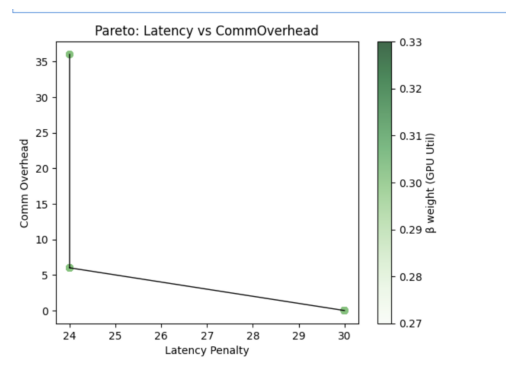

In [7]:
'''
#  Latency vs CommOverhead

# plt.subplot(1,3,2)
plt.scatter(pareto_df["LatencyPen"], pareto_df["CommOverhead"],
            c=pareto_df["beta"], cmap="Greens", alpha=0.8)
plt.xlabel("Latency Penalty")
plt.ylabel("Comm Overhead")
plt.title("Pareto: Latency vs CommOverhead")
df2 = pareto_df.sort_values("LatencyPen")
plt.plot(df2["LatencyPen"], df2["CommOverhead"], color="black", linewidth=1)
# plt.colorbar(label="β weight (GPU Util)")
plt.show()
'''

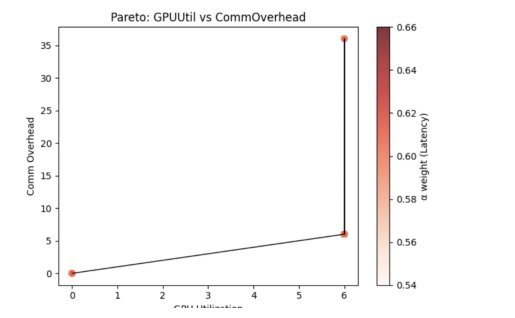

In [8]:
'''
# Plot 3: GPUUtil vs CommOverhead

# plt.subplot(1,3,3)
plt.scatter(pareto_df["GPUUtil"], pareto_df["CommOverhead"],
            c=pareto_df["alpha"], cmap="Reds", alpha=0.8)
plt.xlabel("GPU Utilization")
plt.ylabel("Comm Overhead")
plt.title("Pareto: GPUUtil vs CommOverhead")
df3 = pareto_df.sort_values("GPUUtil")
plt.plot(df3["GPUUtil"], df3["CommOverhead"], color="black", linewidth=1)
plt.colorbar(label="α weight (Latency)")

plt.tight_layout()
plt.show()
'''


### Analyzing the plots:
- Latency vs CommOverhead: shows the trade-off between prioritizing older jobs (lower latency penalty) and reducing splitting/coordination (lower comm overhead).
- Latency vs GPUUtil: shows the trade-off between fairness (low latency penalty) and GPU efficiency (high GPU utilization).
- GPUUtil vs CommOverhead: shows that pushing higher GPU utilization often increases splitting, raising communication overhead.

### (5) Conclusion
This project shows how multi-objective optimization can help design an effective cluster job scheduler. It balances the competing goals of fairness (latency), efficiency (GPU usage), and operational cost (communication overhead). We formulated the problem in GAMSPy and examined weighted, lexicographic, and stochastic extensions. This approach reveals that different priority settings create distinct trade-offs, which we can explore using Pareto analysis.

The results indicate that no single scheduling policy works best in every situation. Decision-makers need to select solutions based on acceptable compromises among objectives and their ability to handle uncertainty. The proposed framework offers a flexible foundation for analyzing these trade-offs and for making informed scheduling decisions in real-world heterogeneous compute clusters.

### (6) Future Scope
Several meaningful extensions could further improve this project. First, the model could be expanded to a dynamic or rolling-horizon scheduling framework. In this setup, jobs would arrive over time, and decisions would be updated regularly instead of being made in one fixed batch. Second, more realistic stochastic modeling could be introduced by learning scenario probabilities or runtime distributions directly from historical data instead of relying on manually defined scenarios. Third, the communication overhead model could be refined by using network topology-aware costs to capture rack-level or inter-switch communication delays.

From a methodological viewpoint, future work could explore multi-objective methods like goal programming. Finally, combining this optimization model with a simulation or real cluster trace replay would help validate the scheduling policies under realistic system dynamics and workloads.